In [1]:
import os
import math
import time
import argparse
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss, Module
from torch.optim.lr_scheduler import ExponentialLR
from torchmetrics import AUROC, Accuracy, MeanSquaredError
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

from torch_frame import stype
from torch_frame.data import Dataset, DataLoader
from torch_frame.datasets import (
    ForestCoverType, KDDCensusIncome, DataFrameBenchmark,
    AdultCensusIncome, BankMarketing, Dota2
)
from torch_frame.gbdt import CatBoost, LightGBM, XGBoost
from torch_frame.nn import (
    EmbeddingEncoder, FTTransformer, LinearBucketEncoder,
    LinearEncoder, LinearPeriodicEncoder, ResNet, TabNet, TabTransformer
)
from torch_frame.nn.models import (
    MLP, ExcelFormer, Trompt
)
from torch_frame.typing import TaskType



# Use GPU for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
df = pd.read_csv("heart_disease.csv")

# AutoEncoder

In [3]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded  # Bottleneck layer 값 반환

In [4]:
# Target은 AutoEncoder X
X_only = df.drop(columns=["target"])

# continuous만 적용 예정
continuous_vars = X_only.select_dtypes(include=["int32", "int64", "float32", "float64"]).columns
categorical_vars = X_only.select_dtypes(include=["object"]).columns

# 모델 생성
input_dim = X_only[continuous_vars].shape[1]  # Feature 개수
hidden_dim = input_dim  # 축소 후 차원 (이 크기의 절반이 새로 만들어진 feature의 수)
autoencoder = Autoencoder(input_dim, hidden_dim)

# PyTorch 텐서 변환
X_tensor = torch.tensor(X_only[continuous_vars].values, dtype=torch.float32)

# Optimizer & Loss 설정
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.01)

In [5]:
# 학습
for epoch in range(50):
    optimizer.zero_grad()
    decoded, encoded = autoencoder(X_tensor)  # Bottleneck feature 추출
    loss = criterion(decoded, X_tensor)  # ✅ 디코더 출력과 원본 데이터 비교
    loss.backward()
    optimizer.step()


# Bottleneck feature 추출 (차원 축소된 데이터)
_, X_reduced = autoencoder(X_tensor)
X_reduced = X_reduced.detach().numpy()

# 👉 변환된 Feature를 DataFrame으로 변환
df_reduced = pd.DataFrame(X_reduced, index=df.index, columns=[f"reduced_{i}" for i in range(X_reduced.shape[1])])

# 🎯 원래 Target(y) 컬럼을 붙여서 최종 DataFrame 생성
df_AE = pd.concat([df[categorical_vars], df_reduced, df["target"]], axis=1)

In [6]:
df_AE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   reduced_0  303 non-null    float32
 1   reduced_1  303 non-null    float32
 2   reduced_2  303 non-null    float32
 3   reduced_3  303 non-null    float32
 4   reduced_4  303 non-null    float32
 5   reduced_5  303 non-null    float32
 6   target     303 non-null    int64  
dtypes: float32(6), int64(1)
memory usage: 9.6 KB


# ML

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
import catboost as cb
import xgboost as xgb
from sklearn.model_selection import cross_val_score

In [9]:
# Heart Disease를 종속 변수(y)로 설정
y_col = "target"
y = df_AE[y_col]

# 독립 변수(X) 설정 (Patient_ID 제거)
X = df_AE.drop(columns=[y_col])

# 더미변수화 
categorical_vars = X.select_dtypes(include=["object"]).columns.tolist()

df_encoded = pd.get_dummies(df_AE, columns=categorical_vars)
X = df_encoded.drop(columns=y_col)

In [10]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Model

### Logistic Regression

In [11]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
log_acc = accuracy_score(y_test, y_pred_log)
print(f'Logistic Regression Accuracy: {log_acc:.4f}')

Logistic Regression Accuracy: 0.6484


### Random Forest

In [12]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {rf_acc:.4f}')

Random Forest Accuracy: 0.6044


### Decision Tree

In [13]:
dt_params = {'max_depth': [3, 5, 10, 15, None]}
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='accuracy')
dt_grid.fit(X_train, y_train)
dt_best = dt_grid.best_estimator_

y_pred_dt = dt_best.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)

print("🔹 Decision Tree Results:")
print("Best Parameters:", dt_grid.best_params_)
print("Accuracy:", acc_dt)
print(classification_report(y_test, y_pred_dt))

🔹 Decision Tree Results:
Best Parameters: {'max_depth': 10}
Accuracy: 0.5494505494505495
              precision    recall  f1-score   support

           0       0.50      0.41      0.45        41
           1       0.58      0.66      0.62        50

    accuracy                           0.55        91
   macro avg       0.54      0.54      0.54        91
weighted avg       0.54      0.55      0.54        91



### XGBoost

In [14]:
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print("🔹 XGBoost Classifier Results:")
print("Accuracy:", acc_xgb)
print(classification_report(y_test, y_pred_xgb))

/opt/conda/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [08:01:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔹 XGBoost Classifier Results:
Accuracy: 0.5824175824175825
              precision    recall  f1-score   support

           0       0.55      0.41      0.47        41
           1       0.60      0.72      0.65        50

    accuracy                           0.58        91
   macro avg       0.57      0.57      0.56        91
weighted avg       0.58      0.58      0.57        91



### LightGBM

In [15]:
lgb_model = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=31, learning_rate=0.05, 
                                 n_estimators=200, force_col_wise=True, random_state=42)
lgb_model.fit(X_train, y_train)

y_pred_lgb = lgb_model.predict(X_test)

acc_lgb = accuracy_score(y_test, y_pred_lgb)

print("🔹 LightGBM Model Performance 🔹")
print("Accuracy:", accuracy_score(y_test, y_pred_lgb))
print(classification_report(y_test, y_pred_lgb))

[LightGBM] [Info] Number of positive: 115, number of negative: 97
[LightGBM] [Info] Total Bins 288
[LightGBM] [Info] Number of data points in the train set: 212, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.542453 -> initscore=0.170221
[LightGBM] [Info] Start training from score 0.170221
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

### CatBoost

In [16]:
cat_model = cb.CatBoostClassifier(iterations=200, depth=6, learning_rate=0.05, loss_function='Logloss', verbose=0, random_seed=42)
cat_model.fit(X_train, y_train)

y_pred_cat = cat_model.predict(X_test)

acc_cat = accuracy_score(y_test, y_pred_cat)

print("🔹 CatBoost Model Performance 🔹")
print("Accuracy:", accuracy_score(y_test, y_pred_cat))
print(classification_report(y_test, y_pred_cat))

🔹 CatBoost Model Performance 🔹
Accuracy: 0.5384615384615384
              precision    recall  f1-score   support

           0       0.48      0.32      0.38        41
           1       0.56      0.72      0.63        50

    accuracy                           0.54        91
   macro avg       0.52      0.52      0.51        91
weighted avg       0.53      0.54      0.52        91



# DL

In [20]:
# 분류 task
is_classification = True

In [21]:
from torch_frame import numerical, categorical, text_embedded, embedding

## 칼럼 별 Dtype 지정 
col_to_stype={"reduced_0" : numerical,
              "reduced_1" : numerical,
              "reduced_2" : numerical,
              "reduced_3" : numerical,
              "reduced_4" : numerical,
              "reduced_5" : numerical,
              "target" : categorical}

dataset = Dataset(df=df_AE, 
                  col_to_stype=col_to_stype, 
                  target_col='target')

dataset.materialize()

## split
train_dataset, val_dataset, test_dataset = dataset[:0.6], dataset[0.6:0.7], dataset[0.7:]

### ResNet

In [22]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='adult')
parser.add_argument('--numerical_encoder_type', type=str, default='linear',
                    choices=['linear', 'linearbucket', 'linearperiodic'])
parser.add_argument('--model_type', type=str, default='fttransformer',
                    choices=['fttransformer', 'resnet'])
parser.add_argument('--channels', type=int, default=256)
parser.add_argument('--num_layers', type=int, default=4)
parser.add_argument('--batch_size', type=int, default=512)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=100)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')

_StoreTrueAction(option_strings=['--compile'], dest='compile', nargs=0, const=True, default=False, type=None, choices=None, required=False, help=None, metavar=None)

In [23]:
# Jupyter에서 실행될 때는 sys.argv를 조정
args = parser.parse_args([
    #'--dataset', 'adult',
    '--numerical_encoder_type', 'linear',
    '--model_type', 'resnet',       # fttransformer : FT-T / resnet : ResNet
    '--channels', '256',
    '--num_layers', '4',
    '--batch_size', '256',  # 데이터를 256개씩 한번에 
    '--lr', '0.0001',
    '--epochs', '15',
    '--seed', '0'
])

In [24]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            loss = F.cross_entropy(pred, tf.y.long())
        else:
            loss = F.mse_loss(pred.view(-1), tf.y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count

@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse

In [25]:
from sklearn.model_selection import KFold

# K-Fold 설정
k_folds = args.k_folds if hasattr(args, 'k_folds') else 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=args.seed if hasattr(args, 'seed') else None)

dataset_indices = list(range(len(dataset)))
best_val_metric = 0 if is_classification else float('inf')
best_test_metric = 0 if is_classification else float('inf')

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset_indices)):
    print(f'Fold {fold + 1}/{k_folds}')
    
    # 데이터 분할
    train_dataset = dataset[train_idx]
    val_dataset = dataset[val_idx]
    train_tensor_frame = train_dataset.tensor_frame
    val_tensor_frame = val_dataset.tensor_frame
    
    train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)

    if args.numerical_encoder_type == 'linear':
        numerical_encoder = LinearEncoder()
    elif args.numerical_encoder_type == 'linearbucket':
        numerical_encoder = LinearBucketEncoder()
    elif args.numerical_encoder_type == 'linearperiodic':
        numerical_encoder = LinearPeriodicEncoder()
    else:
        raise ValueError(
            f'Unsupported encoder type: {args.numerical_encoder_type}')

    stype_encoder_dict = {
    stype.categorical: EmbeddingEncoder(),
    stype.numerical: numerical_encoder,
}
    
    # 모델 초기화
    if args.model_type == 'fttransformer':
        model = FTTransformer(
            channels=args.channels,
            out_channels = 2,
            num_layers=args.num_layers,
            col_stats=dataset.col_stats,
            col_names_dict=train_tensor_frame.col_names_dict,
            stype_encoder_dict=stype_encoder_dict,
        ).to(device)
    elif args.model_type == 'resnet':
        model = ResNet(
            channels=args.channels,
            out_channels = 2,
            num_layers=args.num_layers,
            col_stats=dataset.col_stats,
            col_names_dict=train_tensor_frame.col_names_dict,
        ).to(device)
    else:
        raise ValueError(f'Unsupported model type: {args.model_type}')
    
    model = torch.compile(model, dynamic=True) if args.compile else model
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)
    
    metric = 'Acc'
    
    # 훈련
    for epoch in range(1, args.epochs + 1):
        train_loss = train(epoch)
        train_metric = test(train_loader)
        val_metric = test(val_loader)
        
        if is_classification and val_metric > best_val_metric:
            best_val_metric = val_metric
            best_test_metric = test(val_loader)
        elif not is_classification and val_metric < best_val_metric:
            best_val_metric = val_metric
            best_test_metric = test(val_loader)
        
        print(f'Fold {fold + 1}, Epoch {epoch}: Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
              f'Val {metric}: {val_metric:.4f}')

print(f'Final Best Val {metric}: {best_val_metric:.4f}, Final Best Test {metric}: {best_test_metric:.4f}')


Fold 1/5


Epoch: 1: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


Fold 1, Epoch 1: Train Loss: 0.7096, Train Acc: 0.5537, Val Acc: 0.6066


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 59.02it/s]


Fold 1, Epoch 2: Train Loss: 0.7053, Train Acc: 0.5289, Val Acc: 0.4426


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 62.98it/s]


Fold 1, Epoch 3: Train Loss: 0.6907, Train Acc: 0.5289, Val Acc: 0.5082


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 73.87it/s]


Fold 1, Epoch 4: Train Loss: 0.7311, Train Acc: 0.5702, Val Acc: 0.5410


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 95.51it/s]


Fold 1, Epoch 5: Train Loss: 0.6945, Train Acc: 0.6157, Val Acc: 0.5574


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 90.13it/s]


Fold 1, Epoch 6: Train Loss: 0.6885, Train Acc: 0.6074, Val Acc: 0.6230


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 108.95it/s]


Fold 1, Epoch 7: Train Loss: 0.6984, Train Acc: 0.5826, Val Acc: 0.6393


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 115.58it/s]


Fold 1, Epoch 8: Train Loss: 0.6927, Train Acc: 0.6033, Val Acc: 0.6393


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 118.05it/s]


Fold 1, Epoch 9: Train Loss: 0.7031, Train Acc: 0.6074, Val Acc: 0.6393


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 119.41it/s]


Fold 1, Epoch 10: Train Loss: 0.6884, Train Acc: 0.6074, Val Acc: 0.6393


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 109.79it/s]


Fold 1, Epoch 11: Train Loss: 0.6718, Train Acc: 0.5950, Val Acc: 0.6557


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 89.76it/s]


Fold 1, Epoch 12: Train Loss: 0.6826, Train Acc: 0.6322, Val Acc: 0.6066


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 80.22it/s]


Fold 1, Epoch 13: Train Loss: 0.6662, Train Acc: 0.6488, Val Acc: 0.5902


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 84.49it/s]


Fold 1, Epoch 14: Train Loss: 0.6912, Train Acc: 0.6364, Val Acc: 0.5902


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 86.68it/s]


Fold 1, Epoch 15: Train Loss: 0.6802, Train Acc: 0.6488, Val Acc: 0.5738
Fold 2/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 81.97it/s]


Fold 2, Epoch 1: Train Loss: 0.8175, Train Acc: 0.5620, Val Acc: 0.4754


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 99.32it/s]


Fold 2, Epoch 2: Train Loss: 0.7242, Train Acc: 0.5744, Val Acc: 0.5082


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 95.06it/s]


Fold 2, Epoch 3: Train Loss: 0.7001, Train Acc: 0.4421, Val Acc: 0.5246


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 89.51it/s]


Fold 2, Epoch 4: Train Loss: 0.7088, Train Acc: 0.4421, Val Acc: 0.5246


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 62.76it/s]


Fold 2, Epoch 5: Train Loss: 0.7132, Train Acc: 0.4421, Val Acc: 0.5246


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 70.92it/s]


Fold 2, Epoch 6: Train Loss: 0.7217, Train Acc: 0.4545, Val Acc: 0.4918


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 104.74it/s]


Fold 2, Epoch 7: Train Loss: 0.6982, Train Acc: 0.4669, Val Acc: 0.4918


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 109.80it/s]


Fold 2, Epoch 8: Train Loss: 0.6800, Train Acc: 0.5702, Val Acc: 0.5738


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 106.34it/s]


Fold 2, Epoch 9: Train Loss: 0.7092, Train Acc: 0.6364, Val Acc: 0.5246


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 106.03it/s]


Fold 2, Epoch 10: Train Loss: 0.6847, Train Acc: 0.6198, Val Acc: 0.4590


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 109.80it/s]


Fold 2, Epoch 11: Train Loss: 0.6880, Train Acc: 0.6322, Val Acc: 0.4590


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 112.60it/s]


Fold 2, Epoch 12: Train Loss: 0.6768, Train Acc: 0.6074, Val Acc: 0.4590


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 112.73it/s]


Fold 2, Epoch 13: Train Loss: 0.6751, Train Acc: 0.5992, Val Acc: 0.4426


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 114.18it/s]


Fold 2, Epoch 14: Train Loss: 0.6888, Train Acc: 0.6033, Val Acc: 0.4426


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 108.95it/s]


Fold 2, Epoch 15: Train Loss: 0.6769, Train Acc: 0.6198, Val Acc: 0.4590
Fold 3/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 64.07it/s]


Fold 3, Epoch 1: Train Loss: 0.7150, Train Acc: 0.5331, Val Acc: 0.5902


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 91.79it/s]


Fold 3, Epoch 2: Train Loss: 0.7084, Train Acc: 0.5331, Val Acc: 0.5902


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 102.14it/s]


Fold 3, Epoch 3: Train Loss: 0.7376, Train Acc: 0.5331, Val Acc: 0.5902


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 85.52it/s]


Fold 3, Epoch 4: Train Loss: 0.7145, Train Acc: 0.5331, Val Acc: 0.5902


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 83.90it/s]


Fold 3, Epoch 5: Train Loss: 0.7176, Train Acc: 0.5372, Val Acc: 0.5902


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 77.63it/s]


Fold 3, Epoch 6: Train Loss: 0.7161, Train Acc: 0.5413, Val Acc: 0.5902


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 82.44it/s]


Fold 3, Epoch 7: Train Loss: 0.6863, Train Acc: 0.5455, Val Acc: 0.5902


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 57.50it/s]


Fold 3, Epoch 8: Train Loss: 0.6883, Train Acc: 0.5331, Val Acc: 0.6230


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 83.64it/s]


Fold 3, Epoch 9: Train Loss: 0.6707, Train Acc: 0.5579, Val Acc: 0.6557


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 75.27it/s]


Fold 3, Epoch 10: Train Loss: 0.6983, Train Acc: 0.5702, Val Acc: 0.6885


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 59.88it/s]


Fold 3, Epoch 11: Train Loss: 0.7149, Train Acc: 0.5744, Val Acc: 0.6393


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 116.03it/s]


Fold 3, Epoch 12: Train Loss: 0.7174, Train Acc: 0.5909, Val Acc: 0.6066


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 105.01it/s]


Fold 3, Epoch 13: Train Loss: 0.6992, Train Acc: 0.5950, Val Acc: 0.6066


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 77.06it/s]


Fold 3, Epoch 14: Train Loss: 0.7077, Train Acc: 0.5868, Val Acc: 0.6066


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 78.57it/s]


Fold 3, Epoch 15: Train Loss: 0.6791, Train Acc: 0.5868, Val Acc: 0.6230
Fold 4/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 88.94it/s]


Fold 4, Epoch 1: Train Loss: 0.7231, Train Acc: 0.4403, Val Acc: 0.4500


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 77.54it/s]


Fold 4, Epoch 2: Train Loss: 0.7098, Train Acc: 0.4897, Val Acc: 0.3833


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 101.77it/s]


Fold 4, Epoch 3: Train Loss: 0.6962, Train Acc: 0.5062, Val Acc: 0.4833


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 93.06it/s]


Fold 4, Epoch 4: Train Loss: 0.7211, Train Acc: 0.6173, Val Acc: 0.5333


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 88.38it/s]


Fold 4, Epoch 5: Train Loss: 0.6793, Train Acc: 0.5844, Val Acc: 0.6667


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 87.68it/s]


Fold 4, Epoch 6: Train Loss: 0.6892, Train Acc: 0.5926, Val Acc: 0.6333


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 83.83it/s]


Fold 4, Epoch 7: Train Loss: 0.6946, Train Acc: 0.6049, Val Acc: 0.6167


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 81.83it/s]


Fold 4, Epoch 8: Train Loss: 0.7001, Train Acc: 0.6049, Val Acc: 0.6167


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 80.13it/s]


Fold 4, Epoch 9: Train Loss: 0.6947, Train Acc: 0.6008, Val Acc: 0.6500


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 83.23it/s]


Fold 4, Epoch 10: Train Loss: 0.7122, Train Acc: 0.6337, Val Acc: 0.6667


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 80.64it/s]


Fold 4, Epoch 11: Train Loss: 0.6951, Train Acc: 0.6214, Val Acc: 0.6000


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 84.54it/s]


Fold 4, Epoch 12: Train Loss: 0.6801, Train Acc: 0.6008, Val Acc: 0.5333


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 77.01it/s]


Fold 4, Epoch 13: Train Loss: 0.6865, Train Acc: 0.6132, Val Acc: 0.5000


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 71.29it/s]


Fold 4, Epoch 14: Train Loss: 0.6809, Train Acc: 0.6173, Val Acc: 0.4833


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 73.10it/s]


Fold 4, Epoch 15: Train Loss: 0.6818, Train Acc: 0.6214, Val Acc: 0.4500
Fold 5/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 89.96it/s]


Fold 5, Epoch 1: Train Loss: 0.7149, Train Acc: 0.5638, Val Acc: 0.5167


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 93.50it/s]


Fold 5, Epoch 2: Train Loss: 0.6676, Train Acc: 0.5720, Val Acc: 0.5167


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 85.26it/s]


Fold 5, Epoch 3: Train Loss: 0.7173, Train Acc: 0.5802, Val Acc: 0.5000


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 81.33it/s]


Fold 5, Epoch 4: Train Loss: 0.7115, Train Acc: 0.5926, Val Acc: 0.5000


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 80.33it/s]


Fold 5, Epoch 5: Train Loss: 0.6934, Train Acc: 0.5926, Val Acc: 0.5000


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 81.40it/s]


Fold 5, Epoch 6: Train Loss: 0.6972, Train Acc: 0.5967, Val Acc: 0.5000


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 81.46it/s]


Fold 5, Epoch 7: Train Loss: 0.7071, Train Acc: 0.5926, Val Acc: 0.5167


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 82.42it/s]


Fold 5, Epoch 8: Train Loss: 0.6850, Train Acc: 0.5967, Val Acc: 0.5167


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 72.75it/s]


Fold 5, Epoch 9: Train Loss: 0.7074, Train Acc: 0.5967, Val Acc: 0.5333


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 71.45it/s]


Fold 5, Epoch 10: Train Loss: 0.6798, Train Acc: 0.6049, Val Acc: 0.5333


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 84.63it/s]


Fold 5, Epoch 11: Train Loss: 0.6562, Train Acc: 0.6008, Val Acc: 0.5000


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 73.10it/s]


Fold 5, Epoch 12: Train Loss: 0.6968, Train Acc: 0.6091, Val Acc: 0.5333


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 75.15it/s]


Fold 5, Epoch 13: Train Loss: 0.6776, Train Acc: 0.6091, Val Acc: 0.5333


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 81.76it/s]


Fold 5, Epoch 14: Train Loss: 0.6759, Train Acc: 0.6173, Val Acc: 0.5333


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 73.16it/s]


Fold 5, Epoch 15: Train Loss: 0.6765, Train Acc: 0.6091, Val Acc: 0.5500
Final Best Val Acc: 0.6885, Final Best Test Acc: 0.6885


In [26]:
resnet_score = best_test_metric
resnet_score

0.6885245901639344

### FT-T

In [27]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='adult')
parser.add_argument('--numerical_encoder_type', type=str, default='linear',
                    choices=['linear', 'linearbucket', 'linearperiodic'])
parser.add_argument('--model_type', type=str, default='fttransformer',
                    choices=['fttransformer', 'resnet'])
parser.add_argument('--channels', type=int, default=256)
parser.add_argument('--num_layers', type=int, default=4)
parser.add_argument('--batch_size', type=int, default=512)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=100)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')

_StoreTrueAction(option_strings=['--compile'], dest='compile', nargs=0, const=True, default=False, type=None, choices=None, required=False, help=None, metavar=None)

In [28]:
# Jupyter에서 실행될 때는 sys.argv를 조정
args = parser.parse_args([
    #'--dataset', 'adult',
    '--numerical_encoder_type', 'linear',
    '--model_type', 'fttransformer',       # fttransformer : FT-T / resnet : ResNet
    '--channels', '256',
    '--num_layers', '4',
    '--batch_size', '256',  # 데이터를 256개씩 한번에 
    '--lr', '0.0001',
    '--epochs', '15',
    '--seed', '0'
])

In [29]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            loss = F.cross_entropy(pred, tf.y.long())
        else:
            loss = F.mse_loss(pred.view(-1), tf.y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count

@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse

In [30]:
from sklearn.model_selection import KFold

# K-Fold 설정
k_folds = args.k_folds if hasattr(args, 'k_folds') else 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=args.seed if hasattr(args, 'seed') else None)

dataset_indices = list(range(len(dataset)))
best_val_metric = 0 if is_classification else float('inf')
best_test_metric = 0 if is_classification else float('inf')

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset_indices)):
    print(f'Fold {fold + 1}/{k_folds}')
    
    # 데이터 분할
    train_dataset = dataset[train_idx]
    val_dataset = dataset[val_idx]
    train_tensor_frame = train_dataset.tensor_frame
    val_tensor_frame = val_dataset.tensor_frame
    
    train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)

    if args.numerical_encoder_type == 'linear':
        numerical_encoder = LinearEncoder()
    elif args.numerical_encoder_type == 'linearbucket':
        numerical_encoder = LinearBucketEncoder()
    elif args.numerical_encoder_type == 'linearperiodic':
        numerical_encoder = LinearPeriodicEncoder()
    else:
        raise ValueError(
            f'Unsupported encoder type: {args.numerical_encoder_type}')

    stype_encoder_dict = {
    stype.categorical: EmbeddingEncoder(),
    stype.numerical: numerical_encoder,
}
    
    # 모델 초기화
    if args.model_type == 'fttransformer':
        model = FTTransformer(
            channels=args.channels,
            out_channels = 2,
            num_layers=args.num_layers,
            col_stats=dataset.col_stats,
            col_names_dict=train_tensor_frame.col_names_dict,
            stype_encoder_dict=stype_encoder_dict,
        ).to(device)
    elif args.model_type == 'resnet':
        model = ResNet(
            channels=args.channels,
            out_channels = 2,
            num_layers=args.num_layers,
            col_stats=dataset.col_stats,
            col_names_dict=train_tensor_frame.col_names_dict,
        ).to(device)
    else:
        raise ValueError(f'Unsupported model type: {args.model_type}')
    
    model = torch.compile(model, dynamic=True) if args.compile else model
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)
    
    metric = 'Acc'
    
    # 훈련
    for epoch in range(1, args.epochs + 1):
        train_loss = train(epoch)
        train_metric = test(train_loader)
        val_metric = test(val_loader)
        
        if is_classification and val_metric > best_val_metric:
            best_val_metric = val_metric
            best_test_metric = test(val_loader)
        elif not is_classification and val_metric < best_val_metric:
            best_val_metric = val_metric
            best_test_metric = test(val_loader)
        
        print(f'Fold {fold + 1}, Epoch {epoch}: Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
              f'Val {metric}: {val_metric:.4f}')

print(f'Final Best Val {metric}: {best_val_metric:.4f}, Final Best Test {metric}: {best_test_metric:.4f}')


Fold 1/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 39.92it/s]


Fold 1, Epoch 1: Train Loss: 0.9910, Train Acc: 0.4669, Val Acc: 0.4426


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 57.17it/s]


Fold 1, Epoch 2: Train Loss: 0.7861, Train Acc: 0.5496, Val Acc: 0.6066


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 68.60it/s]


Fold 1, Epoch 3: Train Loss: 0.7014, Train Acc: 0.5413, Val Acc: 0.5574


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 65.75it/s]


Fold 1, Epoch 4: Train Loss: 0.6917, Train Acc: 0.5413, Val Acc: 0.5574


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 39.17it/s]


Fold 1, Epoch 5: Train Loss: 0.6975, Train Acc: 0.5413, Val Acc: 0.5574


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 47.44it/s]


Fold 1, Epoch 6: Train Loss: 0.7245, Train Acc: 0.5413, Val Acc: 0.5574


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 50.27it/s]


Fold 1, Epoch 7: Train Loss: 0.7115, Train Acc: 0.5413, Val Acc: 0.5574


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 54.92it/s]


Fold 1, Epoch 8: Train Loss: 0.6861, Train Acc: 0.5413, Val Acc: 0.5574


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 53.46it/s]


Fold 1, Epoch 9: Train Loss: 0.6829, Train Acc: 0.5413, Val Acc: 0.5574


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 52.97it/s]


Fold 1, Epoch 10: Train Loss: 0.6811, Train Acc: 0.5950, Val Acc: 0.6066


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 53.52it/s]


Fold 1, Epoch 11: Train Loss: 0.6801, Train Acc: 0.6074, Val Acc: 0.5902


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 49.52it/s]


Fold 1, Epoch 12: Train Loss: 0.6901, Train Acc: 0.5950, Val Acc: 0.5574


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 36.90it/s]


Fold 1, Epoch 13: Train Loss: 0.6902, Train Acc: 0.6116, Val Acc: 0.4918


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 46.06it/s]


Fold 1, Epoch 14: Train Loss: 0.6825, Train Acc: 0.6198, Val Acc: 0.5246


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 43.66it/s]


Fold 1, Epoch 15: Train Loss: 0.6751, Train Acc: 0.6281, Val Acc: 0.5574
Fold 2/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 56.71it/s]


Fold 2, Epoch 1: Train Loss: 0.7088, Train Acc: 0.5826, Val Acc: 0.5738


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 34.39it/s]


Fold 2, Epoch 2: Train Loss: 0.6845, Train Acc: 0.6240, Val Acc: 0.5082


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 65.86it/s]


Fold 2, Epoch 3: Train Loss: 0.6648, Train Acc: 0.6281, Val Acc: 0.4754


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 67.61it/s]


Fold 2, Epoch 4: Train Loss: 0.6775, Train Acc: 0.6405, Val Acc: 0.4918


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 67.44it/s]


Fold 2, Epoch 5: Train Loss: 0.6710, Train Acc: 0.6405, Val Acc: 0.5082


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 67.39it/s]


Fold 2, Epoch 6: Train Loss: 0.6304, Train Acc: 0.6281, Val Acc: 0.4918


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 74.46it/s]


Fold 2, Epoch 7: Train Loss: 0.6566, Train Acc: 0.6364, Val Acc: 0.5738


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 37.06it/s]


Fold 2, Epoch 8: Train Loss: 0.6622, Train Acc: 0.6240, Val Acc: 0.5082


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 38.89it/s]


Fold 2, Epoch 9: Train Loss: 0.6532, Train Acc: 0.6322, Val Acc: 0.5082


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 41.73it/s]


Fold 2, Epoch 10: Train Loss: 0.6505, Train Acc: 0.6488, Val Acc: 0.5246


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 43.19it/s]


Fold 2, Epoch 11: Train Loss: 0.6581, Train Acc: 0.6405, Val Acc: 0.4918


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 48.13it/s]


Fold 2, Epoch 12: Train Loss: 0.6398, Train Acc: 0.6364, Val Acc: 0.4754


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 55.49it/s]


Fold 2, Epoch 13: Train Loss: 0.6507, Train Acc: 0.6281, Val Acc: 0.4918


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 55.51it/s]


Fold 2, Epoch 14: Train Loss: 0.6483, Train Acc: 0.6240, Val Acc: 0.5738


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 49.37it/s]


Fold 2, Epoch 15: Train Loss: 0.6470, Train Acc: 0.6529, Val Acc: 0.5902
Fold 3/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 44.58it/s]


Fold 3, Epoch 1: Train Loss: 0.7753, Train Acc: 0.5331, Val Acc: 0.5902


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 54.60it/s]


Fold 3, Epoch 2: Train Loss: 0.6902, Train Acc: 0.5331, Val Acc: 0.5902


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 58.57it/s]


Fold 3, Epoch 3: Train Loss: 0.7066, Train Acc: 0.5331, Val Acc: 0.5902


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 62.22it/s]


Fold 3, Epoch 4: Train Loss: 0.6998, Train Acc: 0.5909, Val Acc: 0.6393


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 63.86it/s]


Fold 3, Epoch 5: Train Loss: 0.6636, Train Acc: 0.5950, Val Acc: 0.6066


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 47.26it/s]


Fold 3, Epoch 6: Train Loss: 0.6801, Train Acc: 0.5785, Val Acc: 0.6066


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 45.10it/s]


Fold 3, Epoch 7: Train Loss: 0.6666, Train Acc: 0.5702, Val Acc: 0.6230


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 42.00it/s]


Fold 3, Epoch 8: Train Loss: 0.6808, Train Acc: 0.6033, Val Acc: 0.6230


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 41.50it/s]


Fold 3, Epoch 9: Train Loss: 0.6753, Train Acc: 0.6116, Val Acc: 0.6557


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 42.30it/s]


Fold 3, Epoch 10: Train Loss: 0.6845, Train Acc: 0.5909, Val Acc: 0.6230


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 42.89it/s]


Fold 3, Epoch 11: Train Loss: 0.6761, Train Acc: 0.5620, Val Acc: 0.6721


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 42.16it/s]


Fold 3, Epoch 12: Train Loss: 0.6671, Train Acc: 0.5537, Val Acc: 0.6557


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 44.00it/s]


Fold 3, Epoch 13: Train Loss: 0.6986, Train Acc: 0.5620, Val Acc: 0.6721


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 44.41it/s]


Fold 3, Epoch 14: Train Loss: 0.6959, Train Acc: 0.5909, Val Acc: 0.6393


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 41.72it/s]


Fold 3, Epoch 15: Train Loss: 0.6801, Train Acc: 0.6074, Val Acc: 0.6393
Fold 4/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 55.05it/s]


Fold 4, Epoch 1: Train Loss: 0.7334, Train Acc: 0.5309, Val Acc: 0.6000


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 50.44it/s]


Fold 4, Epoch 2: Train Loss: 0.7148, Train Acc: 0.5309, Val Acc: 0.6000


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 72.95it/s]


Fold 4, Epoch 3: Train Loss: 0.6813, Train Acc: 0.5514, Val Acc: 0.6333


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 58.28it/s]


Fold 4, Epoch 4: Train Loss: 0.6899, Train Acc: 0.6091, Val Acc: 0.6167


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 62.57it/s]


Fold 4, Epoch 5: Train Loss: 0.6830, Train Acc: 0.6049, Val Acc: 0.6000


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 71.27it/s]


Fold 4, Epoch 6: Train Loss: 0.6877, Train Acc: 0.6091, Val Acc: 0.6167


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 86.64it/s]


Fold 4, Epoch 7: Train Loss: 0.6554, Train Acc: 0.5967, Val Acc: 0.6167


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 86.30it/s]


Fold 4, Epoch 8: Train Loss: 0.6826, Train Acc: 0.6049, Val Acc: 0.6167


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 81.16it/s]


Fold 4, Epoch 9: Train Loss: 0.6497, Train Acc: 0.5967, Val Acc: 0.6167


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 74.65it/s]


Fold 4, Epoch 10: Train Loss: 0.6547, Train Acc: 0.5967, Val Acc: 0.6167


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 69.17it/s]


Fold 4, Epoch 11: Train Loss: 0.6592, Train Acc: 0.5926, Val Acc: 0.6167


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 45.48it/s]


Fold 4, Epoch 12: Train Loss: 0.6651, Train Acc: 0.6008, Val Acc: 0.6333


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 41.63it/s]


Fold 4, Epoch 13: Train Loss: 0.6518, Train Acc: 0.6132, Val Acc: 0.6333


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 41.35it/s]


Fold 4, Epoch 14: Train Loss: 0.6591, Train Acc: 0.6173, Val Acc: 0.6500


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 42.08it/s]


Fold 4, Epoch 15: Train Loss: 0.6607, Train Acc: 0.6132, Val Acc: 0.6167
Fold 5/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 58.75it/s]


Fold 5, Epoch 1: Train Loss: 0.7490, Train Acc: 0.5556, Val Acc: 0.5000


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 65.01it/s]


Fold 5, Epoch 2: Train Loss: 0.6995, Train Acc: 0.5556, Val Acc: 0.5000


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 66.05it/s]

Fold 5, Epoch 3: Train Loss: 0.7001, Train Acc: 0.5556, Val Acc: 0.5000

Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 62.82it/s]


Fold 5, Epoch 4: Train Loss: 0.6924, Train Acc: 0.5844, Val Acc: 0.5000


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 66.73it/s]


Fold 5, Epoch 5: Train Loss: 0.6950, Train Acc: 0.6091, Val Acc: 0.5667


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 63.52it/s]


Fold 5, Epoch 6: Train Loss: 0.6853, Train Acc: 0.6296, Val Acc: 0.6000


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 64.99it/s]


Fold 5, Epoch 7: Train Loss: 0.6768, Train Acc: 0.6255, Val Acc: 0.5833


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 68.67it/s]


Fold 5, Epoch 8: Train Loss: 0.6942, Train Acc: 0.6255, Val Acc: 0.6000


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 49.72it/s]


Fold 5, Epoch 9: Train Loss: 0.6788, Train Acc: 0.6337, Val Acc: 0.6000


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 39.75it/s]


Fold 5, Epoch 10: Train Loss: 0.6633, Train Acc: 0.6214, Val Acc: 0.6167


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 48.42it/s]


Fold 5, Epoch 11: Train Loss: 0.6629, Train Acc: 0.6049, Val Acc: 0.6000


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 53.79it/s]


Fold 5, Epoch 12: Train Loss: 0.6622, Train Acc: 0.5926, Val Acc: 0.6000


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 42.67it/s]


Fold 5, Epoch 13: Train Loss: 0.6596, Train Acc: 0.5926, Val Acc: 0.5667


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 43.90it/s]


Fold 5, Epoch 14: Train Loss: 0.6748, Train Acc: 0.5967, Val Acc: 0.5667


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 53.96it/s]


Fold 5, Epoch 15: Train Loss: 0.6552, Train Acc: 0.5967, Val Acc: 0.6000
Final Best Val Acc: 0.6721, Final Best Test Acc: 0.6721


In [31]:
ftt_score = best_test_metric
ftt_score

0.6721311475409836

### TabNet

In [32]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default="ForestCoverType",
                    choices=["ForestCoverType", "KDDCensusIncome"])
parser.add_argument('--channels', type=int, default=128)
parser.add_argument('--gamma', type=int, default=1.2)
parser.add_argument('--num_layers', type=int, default=6)
parser.add_argument('--batch_size', type=int, default=4096)
parser.add_argument('--lr', type=float, default=0.005)
parser.add_argument('--epochs', type=int, default=50)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')


args = parser.parse_args([
    "--channels", "256",
    "--num_layers", "4",
    "--batch_size", "256",
    "--lr", "0.0001",
    "--epochs", "15"
])

torch.manual_seed(args.seed)

In [33]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            loss = F.cross_entropy(pred, tf.y.long())
        else:
            loss = F.mse_loss(pred.view(-1), tf.y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count

@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse

In [34]:
from sklearn.model_selection import KFold

# K-Fold 설정
k_folds = args.k_folds if hasattr(args, 'k_folds') else 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=args.seed if hasattr(args, 'seed') else None)

dataset_indices = list(range(len(dataset)))
best_val_metric = 0 if is_classification else float('inf')
best_test_metric = 0 if is_classification else float('inf')

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset_indices)):
    print(f'Fold {fold + 1}/{k_folds}')
    
    # 데이터 분할
    train_dataset = dataset[train_idx]
    val_dataset = dataset[val_idx]
    train_tensor_frame = train_dataset.tensor_frame
    val_tensor_frame = val_dataset.tensor_frame
    
    train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)


    # 모델 초기화
    model = TabNet(
    out_channels = 2,
    num_layers=args.num_layers,
    split_attn_channels=args.channels,
    split_feat_channels=args.channels,
    gamma=args.gamma,
    col_stats=dataset.col_stats,
    col_names_dict=train_tensor_frame.col_names_dict,
    ).to(device)
    
    model = torch.compile(model, dynamic=True) if args.compile else model
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    lr_scheduler = ExponentialLR(optimizer, gamma=0.95)

    
    metric = 'Acc'
    
    # 훈련
    for epoch in range(1, args.epochs + 1):
        train_loss = train(epoch)
        train_metric = test(train_loader)
        val_metric = test(val_loader)
        
        if is_classification and val_metric > best_val_metric:
            best_val_metric = val_metric
            best_test_metric = test(val_loader)
        elif not is_classification and val_metric < best_val_metric:
            best_val_metric = val_metric
            best_test_metric = test(val_loader)
        
        print(f'Fold {fold + 1}, Epoch {epoch}: Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
              f'Val {metric}: {val_metric:.4f}')

print(f'Final Best Val {metric}: {best_val_metric:.4f}, Final Best Test {metric}: {best_test_metric:.4f}')


Fold 1/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 68.78it/s]


Fold 1, Epoch 1: Train Loss: 0.6905, Train Acc: 0.5413, Val Acc: 0.5574


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 84.05it/s]


Fold 1, Epoch 2: Train Loss: 0.6883, Train Acc: 0.5496, Val Acc: 0.5410


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 33.98it/s]


Fold 1, Epoch 3: Train Loss: 0.6867, Train Acc: 0.5579, Val Acc: 0.5902


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 39.81it/s]


Fold 1, Epoch 4: Train Loss: 0.6850, Train Acc: 0.5744, Val Acc: 0.6230


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 39.78it/s]


Fold 1, Epoch 5: Train Loss: 0.6834, Train Acc: 0.5785, Val Acc: 0.6393


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 42.64it/s]


Fold 1, Epoch 6: Train Loss: 0.6818, Train Acc: 0.5950, Val Acc: 0.6230


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 55.19it/s]


Fold 1, Epoch 7: Train Loss: 0.6803, Train Acc: 0.5909, Val Acc: 0.6393


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 52.25it/s]


Fold 1, Epoch 8: Train Loss: 0.6789, Train Acc: 0.5992, Val Acc: 0.6230


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 52.46it/s]


Fold 1, Epoch 9: Train Loss: 0.6777, Train Acc: 0.6116, Val Acc: 0.6230


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 52.02it/s]


Fold 1, Epoch 10: Train Loss: 0.6763, Train Acc: 0.6116, Val Acc: 0.6230


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 51.22it/s]


Fold 1, Epoch 11: Train Loss: 0.6752, Train Acc: 0.6074, Val Acc: 0.6230


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 47.13it/s]


Fold 1, Epoch 12: Train Loss: 0.6750, Train Acc: 0.6074, Val Acc: 0.6230


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 56.26it/s]


Fold 1, Epoch 13: Train Loss: 0.6730, Train Acc: 0.6074, Val Acc: 0.6230


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 51.07it/s]


Fold 1, Epoch 14: Train Loss: 0.6719, Train Acc: 0.6116, Val Acc: 0.6230


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 48.99it/s]


Fold 1, Epoch 15: Train Loss: 0.6716, Train Acc: 0.6116, Val Acc: 0.6230
Fold 2/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 64.91it/s]


Fold 2, Epoch 1: Train Loss: 0.6886, Train Acc: 0.5620, Val Acc: 0.4754


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 79.53it/s]


Fold 2, Epoch 2: Train Loss: 0.6853, Train Acc: 0.5909, Val Acc: 0.4590


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 80.28it/s]


Fold 2, Epoch 3: Train Loss: 0.6824, Train Acc: 0.5744, Val Acc: 0.4918


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 70.64it/s]


Fold 2, Epoch 4: Train Loss: 0.6792, Train Acc: 0.5826, Val Acc: 0.4754


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 62.21it/s]


Fold 2, Epoch 5: Train Loss: 0.6759, Train Acc: 0.5868, Val Acc: 0.4590


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 76.60it/s]


Fold 2, Epoch 6: Train Loss: 0.6727, Train Acc: 0.5992, Val Acc: 0.4754


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 78.28it/s]


Fold 2, Epoch 7: Train Loss: 0.6696, Train Acc: 0.5992, Val Acc: 0.4590


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 44.92it/s]


Fold 2, Epoch 8: Train Loss: 0.6667, Train Acc: 0.6074, Val Acc: 0.4918


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 47.77it/s]


Fold 2, Epoch 9: Train Loss: 0.6637, Train Acc: 0.6116, Val Acc: 0.4918


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 70.13it/s]


Fold 2, Epoch 10: Train Loss: 0.6617, Train Acc: 0.6240, Val Acc: 0.4918


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 58.52it/s]


Fold 2, Epoch 11: Train Loss: 0.6588, Train Acc: 0.6240, Val Acc: 0.4754


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 38.44it/s]


Fold 2, Epoch 12: Train Loss: 0.6550, Train Acc: 0.6281, Val Acc: 0.4754


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s]


Fold 2, Epoch 13: Train Loss: 0.6524, Train Acc: 0.6281, Val Acc: 0.4754


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 50.85it/s]


Fold 2, Epoch 14: Train Loss: 0.6519, Train Acc: 0.6281, Val Acc: 0.4918


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 53.82it/s]


Fold 2, Epoch 15: Train Loss: 0.6471, Train Acc: 0.6281, Val Acc: 0.4918
Fold 3/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 37.05it/s]


Fold 3, Epoch 1: Train Loss: 0.6958, Train Acc: 0.4669, Val Acc: 0.4098


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 39.15it/s]


Fold 3, Epoch 2: Train Loss: 0.6949, Train Acc: 0.4711, Val Acc: 0.4098


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 38.93it/s]


Fold 3, Epoch 3: Train Loss: 0.6931, Train Acc: 0.4876, Val Acc: 0.4262


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 36.10it/s]


Fold 3, Epoch 4: Train Loss: 0.6918, Train Acc: 0.5372, Val Acc: 0.4590


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 54.09it/s]


Fold 3, Epoch 5: Train Loss: 0.6906, Train Acc: 0.5331, Val Acc: 0.4918


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 58.24it/s]


Fold 3, Epoch 6: Train Loss: 0.6894, Train Acc: 0.5289, Val Acc: 0.5082


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 55.59it/s]


Fold 3, Epoch 7: Train Loss: 0.6880, Train Acc: 0.5248, Val Acc: 0.5246


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 53.77it/s]


Fold 3, Epoch 8: Train Loss: 0.6868, Train Acc: 0.5413, Val Acc: 0.5902


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 52.78it/s]


Fold 3, Epoch 9: Train Loss: 0.6854, Train Acc: 0.5579, Val Acc: 0.5902


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 58.74it/s]


Fold 3, Epoch 10: Train Loss: 0.6841, Train Acc: 0.5661, Val Acc: 0.6066


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 66.81it/s]


Fold 3, Epoch 11: Train Loss: 0.6825, Train Acc: 0.5579, Val Acc: 0.6230


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 49.41it/s]


Fold 3, Epoch 12: Train Loss: 0.6808, Train Acc: 0.5579, Val Acc: 0.6230


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 37.91it/s]


Fold 3, Epoch 13: Train Loss: 0.6792, Train Acc: 0.5785, Val Acc: 0.6557


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 35.82it/s]


Fold 3, Epoch 14: Train Loss: 0.6774, Train Acc: 0.5868, Val Acc: 0.6721


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 42.76it/s]


Fold 3, Epoch 15: Train Loss: 0.6752, Train Acc: 0.5950, Val Acc: 0.6557
Fold 4/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 54.29it/s]


Fold 4, Epoch 1: Train Loss: 0.6930, Train Acc: 0.5144, Val Acc: 0.6000


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 64.53it/s]


Fold 4, Epoch 2: Train Loss: 0.6910, Train Acc: 0.5391, Val Acc: 0.6333


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 60.91it/s]


Fold 4, Epoch 3: Train Loss: 0.6894, Train Acc: 0.5638, Val Acc: 0.6333


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 75.67it/s]


Fold 4, Epoch 4: Train Loss: 0.6879, Train Acc: 0.5761, Val Acc: 0.6333


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 71.25it/s]


Fold 4, Epoch 5: Train Loss: 0.6861, Train Acc: 0.5926, Val Acc: 0.6333


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 66.61it/s]


Fold 4, Epoch 6: Train Loss: 0.6838, Train Acc: 0.5885, Val Acc: 0.6333


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 91.96it/s]


Fold 4, Epoch 7: Train Loss: 0.6814, Train Acc: 0.6008, Val Acc: 0.6167


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 68.11it/s]


Fold 4, Epoch 8: Train Loss: 0.6793, Train Acc: 0.6173, Val Acc: 0.6333


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 70.83it/s]


Fold 4, Epoch 9: Train Loss: 0.6766, Train Acc: 0.6132, Val Acc: 0.6333


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 68.48it/s]


Fold 4, Epoch 10: Train Loss: 0.6737, Train Acc: 0.6214, Val Acc: 0.6333


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 98.43it/s]


Fold 4, Epoch 11: Train Loss: 0.6720, Train Acc: 0.6214, Val Acc: 0.6333


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 91.79it/s]


Fold 4, Epoch 12: Train Loss: 0.6679, Train Acc: 0.6255, Val Acc: 0.6333


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 52.70it/s]


Fold 4, Epoch 13: Train Loss: 0.6719, Train Acc: 0.6255, Val Acc: 0.6500


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 48.03it/s]


Fold 4, Epoch 14: Train Loss: 0.6687, Train Acc: 0.6255, Val Acc: 0.6500


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 53.53it/s]


Fold 4, Epoch 15: Train Loss: 0.6652, Train Acc: 0.6296, Val Acc: 0.6500
Fold 5/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 52.88it/s]


Fold 5, Epoch 1: Train Loss: 0.6932, Train Acc: 0.5556, Val Acc: 0.5000


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 58.01it/s]


Fold 5, Epoch 2: Train Loss: 0.6910, Train Acc: 0.5556, Val Acc: 0.5000


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 54.09it/s]


Fold 5, Epoch 3: Train Loss: 0.6889, Train Acc: 0.5556, Val Acc: 0.5000


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 51.92it/s]


Fold 5, Epoch 4: Train Loss: 0.6872, Train Acc: 0.5556, Val Acc: 0.5000


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 54.32it/s]


Fold 5, Epoch 5: Train Loss: 0.6854, Train Acc: 0.5638, Val Acc: 0.5000


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 37.79it/s]


Fold 5, Epoch 6: Train Loss: 0.6837, Train Acc: 0.5802, Val Acc: 0.5333


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 41.43it/s]


Fold 5, Epoch 7: Train Loss: 0.6817, Train Acc: 0.6132, Val Acc: 0.5333


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 32.67it/s]


Fold 5, Epoch 8: Train Loss: 0.6807, Train Acc: 0.6214, Val Acc: 0.5333


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 48.66it/s]


Fold 5, Epoch 9: Train Loss: 0.6789, Train Acc: 0.6296, Val Acc: 0.5333


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 47.57it/s]


Fold 5, Epoch 10: Train Loss: 0.6769, Train Acc: 0.6132, Val Acc: 0.5667


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 38.98it/s]


Fold 5, Epoch 11: Train Loss: 0.6750, Train Acc: 0.6173, Val Acc: 0.5667


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 35.20it/s]


Fold 5, Epoch 12: Train Loss: 0.6730, Train Acc: 0.6173, Val Acc: 0.5500


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 48.18it/s]


Fold 5, Epoch 13: Train Loss: 0.6754, Train Acc: 0.6214, Val Acc: 0.5500


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 47.19it/s]


Fold 5, Epoch 14: Train Loss: 0.6700, Train Acc: 0.6255, Val Acc: 0.5500


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 80.28it/s]


Fold 5, Epoch 15: Train Loss: 0.6686, Train Acc: 0.6255, Val Acc: 0.5667
Final Best Val Acc: 0.6721, Final Best Test Acc: 0.6721


In [35]:
tabnet_score = best_test_metric
tabnet_score

0.6721311475409836

### Tab_Transformer

In [36]:
# Jupyter에서 실행될 때는 sys.argv를 조정
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='dota2',
                    choices=["adult", "dota2", "bank-marketing"])
parser.add_argument('--channels', type=int, default=32)
parser.add_argument('--num_heads', type=int, default=8)
parser.add_argument('--num_layers', type=int, default=6)
parser.add_argument('--encoder_pad_size', type=int, default=2)
parser.add_argument('--attention_dropout', type=float, default=0.3)
parser.add_argument('--ffn_dropout', type=float, default=0.3)
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=50)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')

args = parser.parse_args([
    '--channels', '256',
    '--num_layers', '4',
    '--batch_size', '256',  # 데이터를 256개씩 한번에 
    '--lr', '0.0001',
    '--epochs', '15',
    '--seed', '0'
])

In [37]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            loss = F.cross_entropy(pred, tf.y.long())
        else:
            loss = F.mse_loss(pred.view(-1), tf.y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count

@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse


In [38]:
from sklearn.model_selection import KFold

# K-Fold 설정
k_folds = args.k_folds if hasattr(args, 'k_folds') else 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=args.seed if hasattr(args, 'seed') else None)

dataset_indices = list(range(len(dataset)))
best_val_metric = 0 if is_classification else float('inf')
best_test_metric = 0 if is_classification else float('inf')

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset_indices)):
    print(f'Fold {fold + 1}/{k_folds}')
    
    # 데이터 분할
    train_dataset = dataset[train_idx]
    val_dataset = dataset[val_idx]
    train_tensor_frame = train_dataset.tensor_frame
    val_tensor_frame = val_dataset.tensor_frame
    
    train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)


    # 모델 초기화
    model = TabTransformer(
    channels=args.channels,
    out_channels= 2,        # stype 문제로 수동으로 설정 
    num_layers=args.num_layers,
    num_heads=args.num_heads,
    encoder_pad_size=args.encoder_pad_size,
    attn_dropout=args.attention_dropout,
    ffn_dropout=args.ffn_dropout,
    col_stats=dataset.col_stats,
    col_names_dict=train_tensor_frame.col_names_dict,
    ).to(device)
    model = torch.compile(model, dynamic=True) if args.compile else model
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    lr_scheduler = ExponentialLR(optimizer, gamma=0.95)
    
    metric = 'Acc'
    
    # 훈련
    for epoch in range(1, args.epochs + 1):
        train_loss = train(epoch)
        train_metric = test(train_loader)
        val_metric = test(val_loader)
        
        if is_classification and val_metric > best_val_metric:
            best_val_metric = val_metric
            best_test_metric = test(val_loader)
        elif not is_classification and val_metric < best_val_metric:
            best_val_metric = val_metric
            best_test_metric = test(val_loader)
        
        print(f'Fold {fold + 1}, Epoch {epoch}: Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
              f'Val {metric}: {val_metric:.4f}')

print(f'Final Best Val {metric}: {best_val_metric:.4f}, Final Best Test {metric}: {best_test_metric:.4f}')


Fold 1/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 100.68it/s]


Fold 1, Epoch 1: Train Loss: 0.7974, Train Acc: 0.4835, Val Acc: 0.4754


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 143.60it/s]


Fold 1, Epoch 2: Train Loss: 0.7955, Train Acc: 0.4669, Val Acc: 0.4590


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 134.93it/s]


Fold 1, Epoch 3: Train Loss: 0.7935, Train Acc: 0.4669, Val Acc: 0.4590


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 95.88it/s]


Fold 1, Epoch 4: Train Loss: 0.7916, Train Acc: 0.4628, Val Acc: 0.4590


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 110.67it/s]


Fold 1, Epoch 5: Train Loss: 0.7897, Train Acc: 0.4711, Val Acc: 0.4426


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 140.35it/s]


Fold 1, Epoch 6: Train Loss: 0.7878, Train Acc: 0.4504, Val Acc: 0.4262


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 202.20it/s]


Fold 1, Epoch 7: Train Loss: 0.7859, Train Acc: 0.4711, Val Acc: 0.4262


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 214.20it/s]


Fold 1, Epoch 8: Train Loss: 0.7841, Train Acc: 0.4793, Val Acc: 0.4262


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 191.28it/s]


Fold 1, Epoch 9: Train Loss: 0.7822, Train Acc: 0.4711, Val Acc: 0.4098


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 192.81it/s]


Fold 1, Epoch 10: Train Loss: 0.7804, Train Acc: 0.4669, Val Acc: 0.4098


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 161.72it/s]


Fold 1, Epoch 11: Train Loss: 0.7786, Train Acc: 0.4793, Val Acc: 0.4098


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 176.52it/s]


Fold 1, Epoch 12: Train Loss: 0.7768, Train Acc: 0.4793, Val Acc: 0.4426


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 140.56it/s]


Fold 1, Epoch 13: Train Loss: 0.7750, Train Acc: 0.4752, Val Acc: 0.4262


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 171.53it/s]


Fold 1, Epoch 14: Train Loss: 0.7733, Train Acc: 0.4711, Val Acc: 0.4262


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 162.97it/s]


Fold 1, Epoch 15: Train Loss: 0.7715, Train Acc: 0.4752, Val Acc: 0.4098
Fold 2/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 105.12it/s]


Fold 2, Epoch 1: Train Loss: 0.7633, Train Acc: 0.4669, Val Acc: 0.4426


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 170.54it/s]

Fold 2, Epoch 2: Train Loss: 0.7609, Train Acc: 0.4463, Val Acc: 0.4426

Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 194.55it/s]


Fold 2, Epoch 3: Train Loss: 0.7585, Train Acc: 0.4339, Val Acc: 0.4426


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 217.68it/s]


Fold 2, Epoch 4: Train Loss: 0.7562, Train Acc: 0.4215, Val Acc: 0.4426


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 209.91it/s]


Fold 2, Epoch 5: Train Loss: 0.7539, Train Acc: 0.4174, Val Acc: 0.4426


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 220.53it/s]


Fold 2, Epoch 6: Train Loss: 0.7516, Train Acc: 0.4256, Val Acc: 0.4590


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 227.82it/s]


Fold 2, Epoch 7: Train Loss: 0.7493, Train Acc: 0.4256, Val Acc: 0.4590


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 225.80it/s]


Fold 2, Epoch 8: Train Loss: 0.7470, Train Acc: 0.4339, Val Acc: 0.4590


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 237.34it/s]


Fold 2, Epoch 9: Train Loss: 0.7448, Train Acc: 0.4298, Val Acc: 0.4754


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 207.32it/s]


Fold 2, Epoch 10: Train Loss: 0.7426, Train Acc: 0.4380, Val Acc: 0.4918


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 199.57it/s]


Fold 2, Epoch 11: Train Loss: 0.7404, Train Acc: 0.4339, Val Acc: 0.4918


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 155.77it/s]


Fold 2, Epoch 12: Train Loss: 0.7382, Train Acc: 0.4339, Val Acc: 0.4918


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 180.38it/s]


Fold 2, Epoch 13: Train Loss: 0.7361, Train Acc: 0.4421, Val Acc: 0.5082


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 199.65it/s]


Fold 2, Epoch 14: Train Loss: 0.7340, Train Acc: 0.4421, Val Acc: 0.5082


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 195.95it/s]


Fold 2, Epoch 15: Train Loss: 0.7319, Train Acc: 0.4339, Val Acc: 0.5082
Fold 3/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 175.79it/s]


Fold 3, Epoch 1: Train Loss: 0.7326, Train Acc: 0.5207, Val Acc: 0.5574


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 192.70it/s]


Fold 3, Epoch 2: Train Loss: 0.7312, Train Acc: 0.5124, Val Acc: 0.5410


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 182.49it/s]


Fold 3, Epoch 3: Train Loss: 0.7297, Train Acc: 0.5248, Val Acc: 0.5410


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 170.94it/s]


Fold 3, Epoch 4: Train Loss: 0.7283, Train Acc: 0.5372, Val Acc: 0.5410


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 162.46it/s]


Fold 3, Epoch 5: Train Loss: 0.7269, Train Acc: 0.5496, Val Acc: 0.5410


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 166.36it/s]


Fold 3, Epoch 6: Train Loss: 0.7256, Train Acc: 0.5537, Val Acc: 0.5410


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 162.98it/s]


Fold 3, Epoch 7: Train Loss: 0.7242, Train Acc: 0.5579, Val Acc: 0.5410


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 164.82it/s]


Fold 3, Epoch 8: Train Loss: 0.7229, Train Acc: 0.5537, Val Acc: 0.5410


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 160.69it/s]


Fold 3, Epoch 9: Train Loss: 0.7215, Train Acc: 0.5579, Val Acc: 0.5410


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 172.01it/s]


Fold 3, Epoch 10: Train Loss: 0.7202, Train Acc: 0.5579, Val Acc: 0.5410


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 173.73it/s]


Fold 3, Epoch 11: Train Loss: 0.7189, Train Acc: 0.5620, Val Acc: 0.5410


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 170.35it/s]


Fold 3, Epoch 12: Train Loss: 0.7176, Train Acc: 0.5537, Val Acc: 0.5738


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 174.72it/s]


Fold 3, Epoch 13: Train Loss: 0.7164, Train Acc: 0.5620, Val Acc: 0.5902


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 177.25it/s]


Fold 3, Epoch 14: Train Loss: 0.7151, Train Acc: 0.5620, Val Acc: 0.5902


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 181.10it/s]


Fold 3, Epoch 15: Train Loss: 0.7139, Train Acc: 0.5702, Val Acc: 0.5902
Fold 4/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 173.14it/s]


Fold 4, Epoch 1: Train Loss: 0.7014, Train Acc: 0.5432, Val Acc: 0.6167


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 184.17it/s]


Fold 4, Epoch 2: Train Loss: 0.7000, Train Acc: 0.5432, Val Acc: 0.6333


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 194.60it/s]


Fold 4, Epoch 3: Train Loss: 0.6986, Train Acc: 0.5473, Val Acc: 0.6167


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 177.03it/s]


Fold 4, Epoch 4: Train Loss: 0.6973, Train Acc: 0.5350, Val Acc: 0.6167


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 165.80it/s]


Fold 4, Epoch 5: Train Loss: 0.6959, Train Acc: 0.5350, Val Acc: 0.6167


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 172.98it/s]


Fold 4, Epoch 6: Train Loss: 0.6946, Train Acc: 0.5267, Val Acc: 0.6167


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 147.23it/s]


Fold 4, Epoch 7: Train Loss: 0.6933, Train Acc: 0.5309, Val Acc: 0.6167


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 104.37it/s]


Fold 4, Epoch 8: Train Loss: 0.6921, Train Acc: 0.5309, Val Acc: 0.6167


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 187.22it/s]


Fold 4, Epoch 9: Train Loss: 0.6908, Train Acc: 0.5350, Val Acc: 0.6167


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 174.11it/s]


Fold 4, Epoch 10: Train Loss: 0.6896, Train Acc: 0.5309, Val Acc: 0.6167


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 180.60it/s]


Fold 4, Epoch 11: Train Loss: 0.6883, Train Acc: 0.5267, Val Acc: 0.6167


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 189.38it/s]


Fold 4, Epoch 12: Train Loss: 0.6871, Train Acc: 0.5185, Val Acc: 0.6167


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 204.38it/s]


Fold 4, Epoch 13: Train Loss: 0.6860, Train Acc: 0.5144, Val Acc: 0.6167


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 202.81it/s]


Fold 4, Epoch 14: Train Loss: 0.6848, Train Acc: 0.5144, Val Acc: 0.6167


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 184.73it/s]


Fold 4, Epoch 15: Train Loss: 0.6837, Train Acc: 0.5144, Val Acc: 0.6167
Fold 5/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 180.79it/s]


Fold 5, Epoch 1: Train Loss: 0.6912, Train Acc: 0.5309, Val Acc: 0.5500


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 176.22it/s]


Fold 5, Epoch 2: Train Loss: 0.6904, Train Acc: 0.5267, Val Acc: 0.5500


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 238.72it/s]


Fold 5, Epoch 3: Train Loss: 0.6895, Train Acc: 0.5226, Val Acc: 0.5500


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 191.34it/s]


Fold 5, Epoch 4: Train Loss: 0.6886, Train Acc: 0.5350, Val Acc: 0.5500


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 197.66it/s]


Fold 5, Epoch 5: Train Loss: 0.6878, Train Acc: 0.5309, Val Acc: 0.5167


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 177.72it/s]


Fold 5, Epoch 6: Train Loss: 0.6869, Train Acc: 0.5350, Val Acc: 0.5333


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 135.26it/s]


Fold 5, Epoch 7: Train Loss: 0.6861, Train Acc: 0.5391, Val Acc: 0.5333


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 208.84it/s]


Fold 5, Epoch 8: Train Loss: 0.6853, Train Acc: 0.5432, Val Acc: 0.5333


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 210.16it/s]


Fold 5, Epoch 9: Train Loss: 0.6845, Train Acc: 0.5350, Val Acc: 0.5167


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 191.54it/s]


Fold 5, Epoch 10: Train Loss: 0.6837, Train Acc: 0.5350, Val Acc: 0.5333


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 163.25it/s]


Fold 5, Epoch 11: Train Loss: 0.6829, Train Acc: 0.5350, Val Acc: 0.5333


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 170.18it/s]


Fold 5, Epoch 12: Train Loss: 0.6821, Train Acc: 0.5473, Val Acc: 0.5167


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 186.99it/s]


Fold 5, Epoch 13: Train Loss: 0.6813, Train Acc: 0.5473, Val Acc: 0.5167


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 158.82it/s]


Fold 5, Epoch 14: Train Loss: 0.6806, Train Acc: 0.5473, Val Acc: 0.5167


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 163.81it/s]


Fold 5, Epoch 15: Train Loss: 0.6798, Train Acc: 0.5473, Val Acc: 0.5167
Final Best Val Acc: 0.6333, Final Best Test Acc: 0.6333


In [39]:
tab_transformer_score = best_test_metric
tab_transformer_score

0.6333333333333333

# 시각화

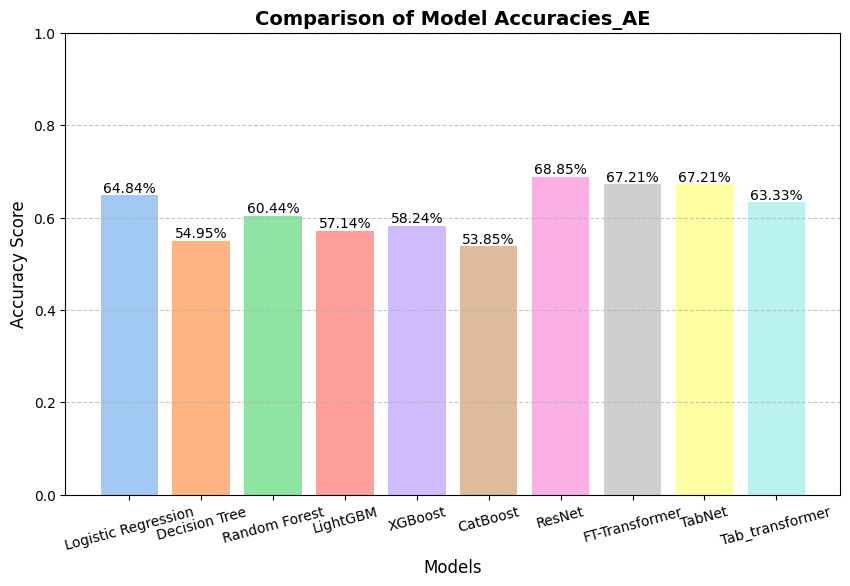

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'LightGBM', 'XGBoost', 'CatBoost', 'ResNet', 'FT-Transformer', 'TabNet', 'Tab_transformer']
accuracies = [log_acc, acc_dt, rf_acc, acc_lgb, acc_xgb, acc_cat, resnet_score, ftt_score, tabnet_score, tab_transformer_score]

colors = sns.color_palette("pastel", len(models))

plt.figure(figsize=(10, 6))

# 바 차트 그리기
bars = plt.bar(models, accuracies, color=colors,  linewidth=1.2)

plt.ylim(0, 1)

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{acc:.2%}",
             ha='center', va='bottom', fontsize=10)


plt.xlabel("Models", fontsize=12)
plt.ylabel("Accuracy Score", fontsize=12)
plt.title("Comparison of Model Accuracies_AE", fontsize=14, fontweight='bold')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()